Идея:
* Попробовать строить модели с большим числом тем и включать регуляризатор отбора тем
* регуляризатор отбора тем нельзя включать сразу
* регуляризатор отбора тем нельзя включать вместе с регуляризатором декоррелирования


status: not done

comp: work



|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|     	|     	|   	|    	|
|   closest by dist original/test  	|     	|     	|    	|    	|
| closest by opt res test/original 	|     	|   	|     	|     	|
| closest by opt res original/test 	|     	|     	|     	|   	|

In [1]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
import matplotlib.pyplot as plt
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')

import distances_helper as dh 
import print_helper as ph
import create_model_helper as cmh
import build_convex_hull_helper as bchh
import test_vs_original_columns_helper as tvsoch
import compare_two_models as ctm

from plot_helper import PlotMaker
from config_helper import ConfigPaths
from scipy.optimize import minimize

0.8.1


In [2]:
config = ConfigPaths('config_sample_m3.cfg')
print config.models_file_name
models_file = open(config.models_file_name, 'a')

plot_maker = PlotMaker()

batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

F:\\topic_modeling\\csi_science_collections.no_git\experiments\pn_model3\np_20_03_no\models.txt


In [3]:
def save_pickle_file(dists, filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def load_pickle_file(filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file
def plot_convex_hull_topics_iterations_distribution(_phi_convex_hull):
    get_iteration_number_fn = lambda x: int(x[x.find('_', 6) + 1 : ])
    phi_convex_hull_iteration_number = [get_iteration_number_fn(col) for col in _phi_convex_hull.columns]
    phi_convex_hull_iteration_number = [(val, phi_convex_hull_iteration_number.count(val), 1.0 * phi_convex_hull_iteration_number.count(val) / len(phi_convex_hull_iteration_number)) for val in set(phi_convex_hull_iteration_number)]
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[1] for x in phi_convex_hull_iteration_number], ax=ax1)
    ax1.set_title('Number of topics from each iteration')
    ax1.set_xlabel('n iteration')

    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[2] for x in phi_convex_hull_iteration_number], ax=ax2)
    ax2.set_title('Number of topics from each iteration (%)')
    ax2.set_xlabel('n iteration')
def plot_convex_hull_columns_change(iterations_info):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    ax1.plot([sum([val['n_topics_to_remove']for val in it['iterations_info_filter']]) for it in iterations_info], 
             color='r', label = 'total')
    ax1.set_title('Num columns to remove')
    get_topic_iteration_fn = lambda x: int(x[x.rfind('_') + 1 :])
    get_topic_filter_iteration_list_fn = lambda x, y: [get_topic_iteration_fn(topic) for topic in x].count(y)
    n_topics_removed_from_current_iteration = [sum([get_topic_filter_iteration_list_fn(val['removed_topics'], indx) for val in it['iterations_info_filter']]) for indx, it in enumerate(iterations_info)]
    ax1.plot(n_topics_removed_from_current_iteration, color='b', label='current iteration')
    ax1.set_xlabel('n iteration')
    ax1.legend()

    ax2.plot([val['phi_convex_hull_shape'][1] for val in iterations_info], color='r')
    ax2.set_title('Num columns of convex hull')
    ax2.set_xlabel('n iteration')
    ax2.legend()
def plot_opt_res_fun(iterations_filtering_info_name):
    %matplotlib inline
    iterations_filtering_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_filtering_info for val in item for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item for x in val['opt_res'].values()] for item in iterations_filtering_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)
def plot_opt_res_fun_filtering(iterations_filtering_info_name):
    iterations_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_info for val in item['iterations_info_filter'] for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item['iterations_info_filter'] for x in val['opt_res'].values()] for item in iterations_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)
def get_phi_granularity(phi):
    return np.mean([get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()])
def get_words_close_to_th_count(col, global_th=0.95):
    cur_sum, sum_count = 0, 0
    for val in col.sort_values()[::-1]:
        if cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_opt_x_granularity(opt):
    return np.mean([get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt.iteritems()])
def get_opt_x_close_to_th_count(opt_x, cut_th=None, global_th=0.95):
    cur_sum, sum_count = 0, 0
    opt_x_val = opt_x.copy()
    if cut_th != None:
        opt_x_val[opt_x_val < cut_th] = 0
    for val in sorted(opt_x_val)[::-1]:
        if val !=0 and cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_and_plot_granularity(phi, opt_to_original, name):
    x_count_grans = [get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean = np.mean(x_count_grans)
    x_count_grans_th = [get_opt_x_close_to_th_count(opt_res.x, cut_th=5*1e-2)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean_th = np.mean(x_count_grans_th)
    grans = [get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()]
    grans_mean = np.mean(grans) 
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    sns.distplot(x_count_grans, color='r', bins=5, ax=ax1)
    sns.distplot(x_count_grans_th, color='b', bins=5, ax=ax1)
    for topic, opt_res in opt_to_original.iteritems():
        ax2.plot(sorted(opt_res.x)[::-1])
    sns.distplot(grans, color='r', bins=5, ax=ax3)
    title = '{} {} \nx_count_grans_mean = {}; th={}'.format(name, phi.shape, x_count_grans_mean, x_count_grans_mean_th)
    ax1.set_title(title)
    title = '{} {} \ngrans_mean = {}'.format(name, phi.shape, grans_mean)
    ax3.set_title(title)

    return x_count_grans, x_count_grans_mean, grans, grans_mean

def plot_different_distances(different_distances, title):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    
    if dh.kl_dist in different_distances.keys():
        vals = different_distances[dh.kl_dist].values.flatten()
        sns.distplot(vals, color='y', ax=ax1, label='kl')
    if dh.kl_sym_dist in different_distances.keys():
        vals = different_distances[dh.kl_sym_dist].values.flatten()
        sns.distplot(vals, color='m', ax=ax1, label='kl_sym')
    
    vals = different_distances[dh.jaccard_dist].values.flatten()
    sns.distplot(vals, color='r', ax=ax2, label='jaccard')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='r', ax=ax3, label='jaccard')

    vals = different_distances[dh.cos_dist].values.flatten()
    sns.distplot(vals,  color='b', ax=ax2, label='cos')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='b', ax=ax3, label='cos')

    vals = different_distances[dh.hellinger_dist].values.flatten()
    sns.distplot(vals, color='g', ax=ax2, label='hellinger')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='g', ax=ax3, label='hellinger')
    ax1.legend()
    ax2.legend()    
    if title != '':
        fig.suptitle(title, fontsize=14, fontweight='bold')
    
def get_distances(phi):
    different_distances = {}
    distances = [dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]
    for dist_fn in distances:
        different_distances[dist_fn] = dh.calculate_distances(dist_fn, phi, phi)
    return different_distances
def save_and_plot(idx, names_list, phi_convex_hull_list, iterations_info_list, iterations_filtering_list):
    save_pickle_file(phi_convex_hull_list[idx], 'phi_convex_hull___' + names_list[idx])
    save_pickle_file(iterations_info_list[idx], 'iterations_info_list___' + names_list[idx])
    save_pickle_file(iterations_filtering_list[idx], 'iterations_filtering_list___' + names_list[idx])

    plot_convex_hull_topics_iterations_distribution(phi_convex_hull_list[idx])
    plot_convex_hull_columns_change(iterations_info_list[idx])

    distances_to_original_list = bchh.calculate_distances(DIST_FN, phi_convex_hull_list[idx], phi_original)
    opt_res_to_original_list = bchh.get_optimization_result(DIST_FN, None, phi_convex_hull_list[idx], phi_original,
                                                       distances_to_original_list[idx], n_closest_topics=N_CLOSEST_TOPICS_COUNT)
    opt_original_to_res_list = bchh.get_optimization_result(DIST_FN, None, phi_original,  phi_convex_hull_list[idx],
                                                       distances_to_original_list[idx].T, n_closest_topics=N_CLOSEST_TOPICS_COUNT)

    _,_,_,_ = get_and_plot_granularity(phi_convex_hull_list[idx], opt_res_to_original_list[idx], names_list[idx])
    _,_,_,_ = get_and_plot_granularity(phi_convex_hull_list[idx], opt_original_to_res_list[idx], names_list[idx])
    plot_dists(opt_res_to_original_list[idx], opt_original_to_res_list[idx], names_list[idx])
    
    different_distances = get_distances(phi_convex_hull_list[idx])
    different_distances_to_original = tvsoch.get_test_to_original_result_different_distances(phi_convex_hull_list[idx], phi_convex_hull_list[idx])
    tvsoch.plot_original_columns_count_different_distances(different_distances_to_original, n_original_columns_count=100)
    plot_different_distances(different_distances)
    return distances_to_original_list, opt_res_to_original_list, opt_original_to_res_list, different_distances, different_distances_to_original


Загрузим оригинальный sample датасет (от model3), до этого скопировав в папку с batches нужные pickle файлы модели.
Сначала провизуалируем по одной итерации каждой новой модели, а потом будем итерационно строить выпуклую оболочку для каждой модели по отдельности и затем сравнивать их. 

In [4]:
phi_original, theta_original = load_pickle_file('phi_model3.p', config.output_batches_path), load_pickle_file('theta_model3.p', config.output_batches_path)
phi_nwt_original = pd.DataFrame(0, index=phi_original.index, columns=[])
print phi_original.shape, theta_original.shape

(2216, 100) (100, 3446)


In [5]:
def check_topic_ok(topic_phi, _debug=False):
    if type(topic_phi) != np.ndarray:
        topic_phi = np.array(topic_phi)
    # sum must be != 0 (after regulizators some topics may be zero)
    topic_sum_rule = np.sum(topic_phi) > 1e-1
    return topic_sum_rule 

def get_distances(phi, distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]):
    different_distances = {}    
    for dist_fn in distances:
        print('Processing {}'.format(dist_fn))
        tmp = dh.calculate_distances(dist_fn, phi, phi)        
        if not np.any(tmp == np.inf) and not np.any(tmp == np.nan):
            different_distances[dist_fn] = tmp
    return different_distances
def reg_experiment(phi_original, phi_test, phi_nwt_original, phi_nwt_test):
    different_inter_distances_closest_1, different_inter_distances_closest_2 = None, None
    different_inter_distances_1, different_inter_distances_2 = None, None
    different_to_original_distances_closest_1, different_to_test_distances_closest_2 = None, None
    different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix = None, None, None
    try:
        ph.print_phi_top_tokens(phi_original, phi_test, n_top_tokens=13)
            
        models_compare_matrix = ctm.print_models_comparasion(phi_original, phi_test, phi_nwt_original, phi_nwt_test)

        % matplotlib inline
        different_inter_distances_closest_1 = tvsoch.get_test_to_original_result_different_distances(phi_original, phi_original)
        tvsoch.plot_original_columns_count_different_distances(different_inter_distances_closest_1, 
                                                               n_original_columns_count=phi_original.shape[1], 
                                                               title='closest by dist inter 1')
        different_inter_distances_closest_2 = tvsoch.get_test_to_original_result_different_distances(phi_test, phi_test)
        tvsoch.plot_original_columns_count_different_distances(different_inter_distances_closest_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by dist inter 2')


        different_inter_distances_1 = get_distances(phi_original)
        plot_different_distances(different_inter_distances_1, 'inter distances 1')
        different_inter_distances_2 = get_distances(phi_test)
        plot_different_distances(different_inter_distances_2, 'inter distances 2')


        different_to_original_distances_closest_1 = tvsoch.get_test_to_original_result_different_distances(phi_test, phi_original)
        tvsoch.plot_original_columns_count_different_distances(different_to_original_distances_closest_1, 
                                                               n_original_columns_count=phi_original.shape[1],
                                                               title='closest by dist test/original')
        different_to_test_distances_closest_2 = tvsoch.get_test_to_original_result_different_distances(phi_original, phi_test)
        tvsoch.plot_original_columns_count_different_distances(different_to_test_distances_closest_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by dist original/test')


        different_to_original_opts_1 = tvsoch.get_test_to_original_opt_result_different_distances(phi_test, phi_original,
                                        distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_to_original_opts_1, 
                                                               n_original_columns_count=phi_original.shape[1],
                                                               title='closest by opt test/original')
        different_to_test_opts_2 = tvsoch.get_test_to_original_opt_result_different_distances(phi_original, phi_test,
                                        distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_to_test_opts_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by opt original/test')


        print different_to_original_opts_1[dh.hellinger_dist][1][1]
        
    except Exception as inst:
        print('An error happened')
        print type(inst)     # the exception instance
        print inst.args      # arguments stored in .args
        print inst           
        ;
    return different_inter_distances_closest_1, different_inter_distances_closest_2, \
           different_inter_distances_1, different_inter_distances_2, \
           different_to_original_distances_closest_1, different_to_test_distances_closest_2, \
           different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix
def print_phi_top_tokens(phi, topic_name, n_top_tokens=13):
    topic = phi.loc[:, topic_name]
    top_tokens_and_weight = ' '.join([u'{0}: {1:.3f}'.format(topic, weight) for topic, weight in topic.sort_values()[::-1][0:n_top_tokens].iteritems() if weight != 0])
    print(topic_name + '| ' + top_tokens_and_weight)

# Choose models
Построить несколько моделей с отбором тем. Выводить число оставшихся необнулившихся колонок фи/тета.

In [6]:
models_count = 100
names_list, models_list, functions_list = [0] * models_count, [0] * models_count, [0] * models_count
phi_list, phi_nwt_list, theta_list = [0] * models_count, [0] * models_count, [0] * models_count
phi_filtered_list, phi_nwt_filtered_list, theta_filtered_list = [0] * models_count, [0] * models_count, [0] * models_count

different_inter_distances_closest_1, different_inter_distances_closest_2 = [0] * models_count, [0] * models_count
different_inter_distances_1, different_inter_distances_2 = [0] * models_count, [0] * models_count
different_to_original_distances_closest_1, different_to_test_distances_closest_2 = [0] * models_count, [0] * models_count
different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix = [0] * models_count, [0] * models_count, [0] * models_count

# different topics number

name = create_model_dtn_20_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 20, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19'])

------------------------------------------------------------ phi ------------------------------------------------------------
topic_0 | стратегия: 0.082 участник: 0.052 ситуация: 0.048 условие: 0.046 трудность: 0.046 игрок: 0.035 цель: 0.033 шанс: 0.029 возможность: 0.026 риска: 0.025 опрос: 0.023 ожидание: 0.020 ответ: 0.019
topic_1 | слово: 0.231 словарь: 0.049 предложение: 0.041 речь: 0.038 русский_язык: 0.036 значение: 0.031 глагол: 0.030 форма: 0.027 правило: 0.019 грамматика: 0.017 тип: 0.016 смысл: 0.014 существительное: 0.014
topic_2 | молекула: 0.150 

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    20.00
non zero ratio                    0.96     0.66
|phi_ij == 0| / n_topics       2126.43  1467.70
|phi_ij > 0.2| / n_topics         0.23     0.10
|phi_ij > 0.1| / n_topics         0.89     0.65
|phi_ij > 0.01| / n_topics       27.16    20.50
|phi_ij > 0.05| / n_topics        2.63     2.25
|phi_ij > 0.001| / n_topics      80.26   138.40
topic_kernel_average_size        23.68   123.55
topic_kernel_average_purity       0.63     0.71
topic_kernel_average_contrast     0.78     0.79

Dist fn = <function kl_sym_dist at 0x000000000BCE9908>, Processed th = 100, original columns count = 20        Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Dist fn = <function cos_dist at 0x000000000BCE9A58>, Processed th = 1.0, original columns count = 20           Column topic_3 not optimized
Column topic_6 not optimized
Column topic_8 not optimized
Dist fn = <function hellinger_dist at 0x000000000BCE9AC8>, Processed th = 1.0, original columns count = 20     

C:\Users\jluka\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Dist fn = <function hellinger_dist at 0x000000000BCE9AC8>, Processed th = 1.0, original columns count = 20     [(u'topic_0', u'topic_17', 0, 17, 0.23819300085393072), (u'topic_1', u'topic_16', 1, 16, 0.25158653905344858), (u'topic_2', u'topic_15', 2, 15, 0.23326194862182131), (u'topic_3', u'topic_14', 3, 14, 0.28338791935021612), (u'topic_4', u'topic_13', 4, 13, 0.29003638286409217), (u'topic_5', u'topic_12', 5, 12, 0.28569792189988136), (u'topic_6', u'topic_11', 6, 11, 0.2809727670503262), (u'topic_7', u'topic_10', 7, 10, 0.26693298324275627), (u'topic_8', u'topic_19', 8, 19, 0.32094956631856886), (u'topic_9', u'topic_18', 9, 18, 0.24037741309679475), (u'topic_10', u'topic_5', 10, 5, 0.27130617131062201), (u'topic_11', u'topic_4', 11, 4, 0.32160290372692374), (u'topic_12', u'topic_3', 12, 3, 0.28682535483141824), (u'topic_13', u'topic_2', 13, 2, 0.30514116342781883), (u'topic_14', u'topic_9', 14, 9, 0.33261643112085204), (u'topic_15', u'topic_8', 15, 8, 0.31270982694731048), (u'topic_

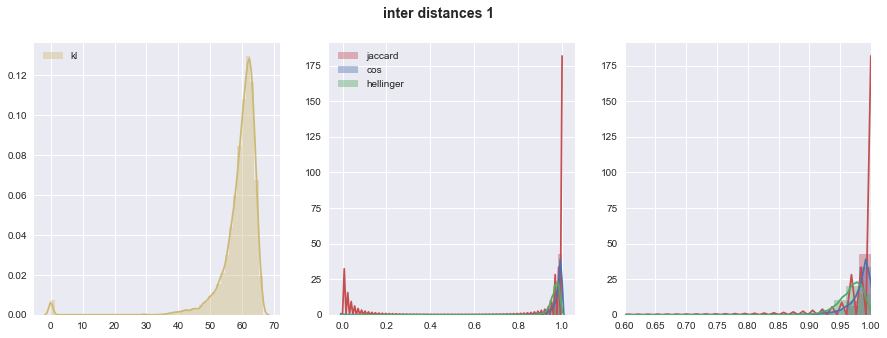

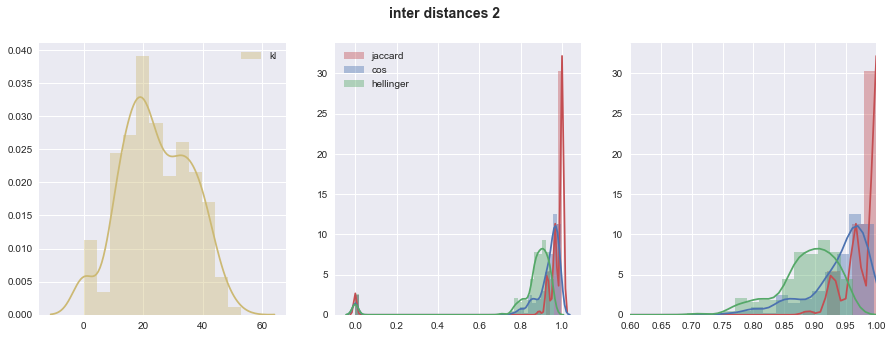

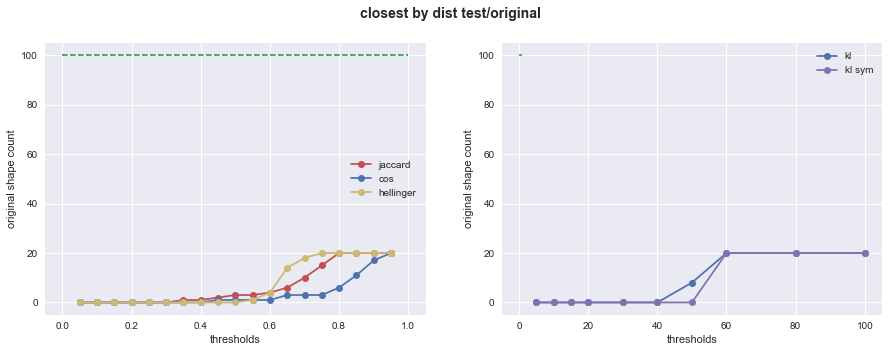

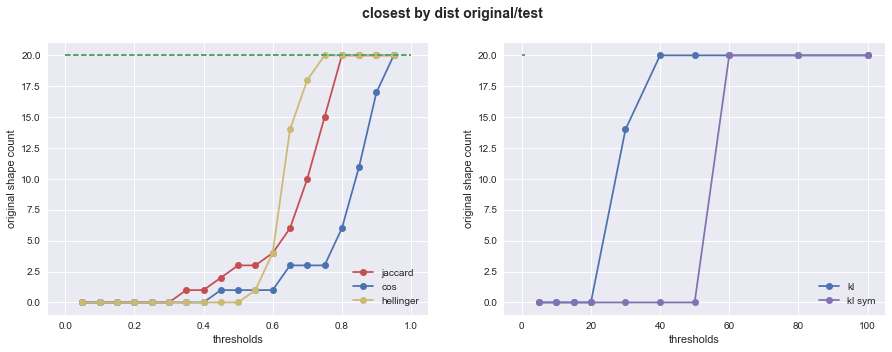

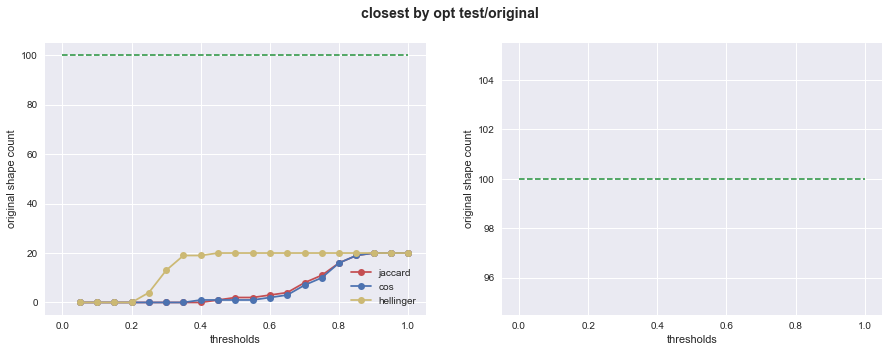

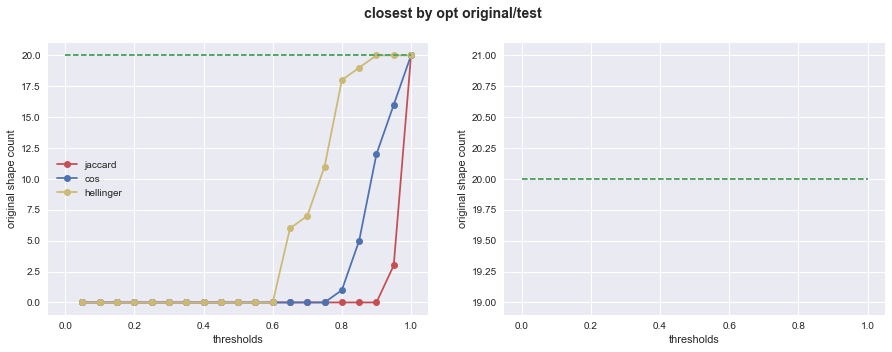

In [7]:
def create_model_dtn_20(n_iteration, model_name='', fit=True, n_topics=20):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 21
functions_list[idx] = create_model_dtn_20
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

*  -> , 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**:  
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|   	|       |       |    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|    	|    	|    	|   	|
| closest by opt res original/test 	|  - 	|   - 	|   -	|    	||
* **Выводы**: 
* **TODO**: 


name = create_model_dtn_50_iter_0, n_topics = 50, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 50, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49'])

------------------------------------------------------------ phi ------------------------------------------------------------
topic_0 | стратегия: 0.082 участник: 0.052 ситуаци

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00    50.00
non zero ratio                    0.96     0.77
|phi_ij == 0| / n_topics       2126.43  1706.08
|phi_ij > 0.2| / n_topics         0.23     0.38
|phi_ij > 0.1| / n_topics         0.89     1.36
|phi_ij > 0.01| / n_topics       27.16    20.76
|phi_ij > 0.05| / n_topics        2.63     2.94
|phi_ij > 0.001| / n_topics      80.26    88.38
topic_kernel_average_size        23.68    47.64
topic_kernel_average_purity       0.63     0.68
topic_kernel_average_contrast     0.78     0.80

Dist fn = <function kl_sym_dist at 0x000000000BCE9908>, Processed th = 100, original columns count = 50        Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Dist fn = <function cos_dist at 0x000000000BCE9A58>, Processed th = 1.0, original columns count = 50           Column topic_40 not optimized
Dist fn = <function cos_dist at 0x000000000BCE9A58>, Processed th = 1.0, original columns count = 50           Column topic_3 not optimized
Column topic_41 not optimized
Column topic_75 not opti

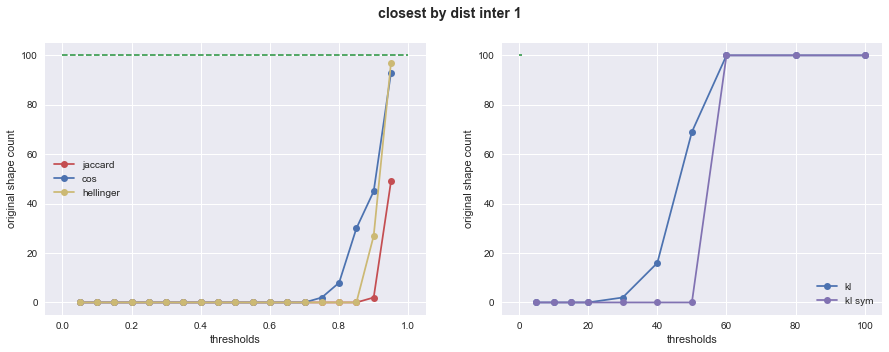

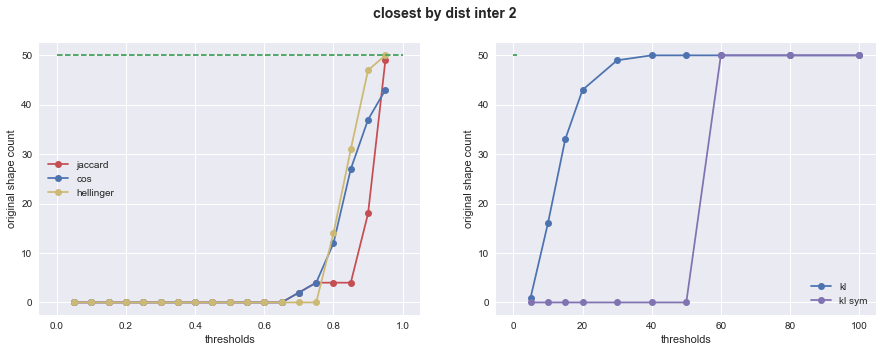

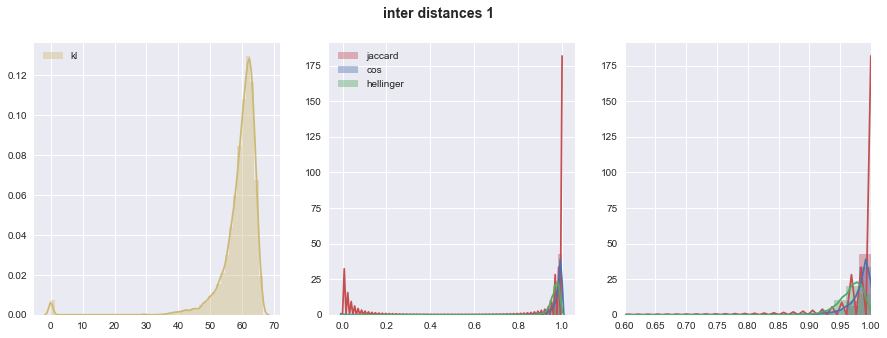

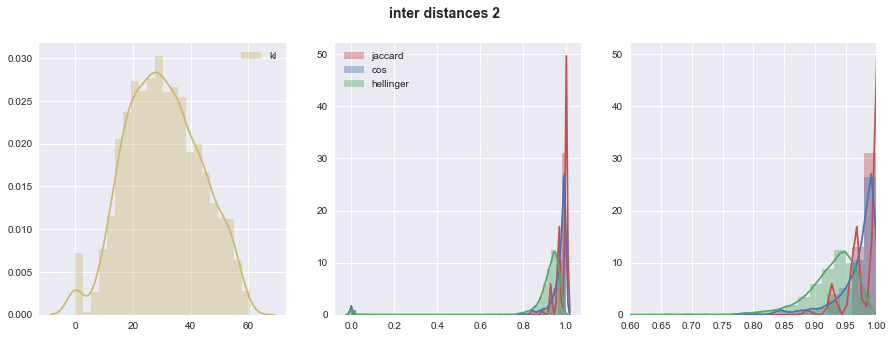

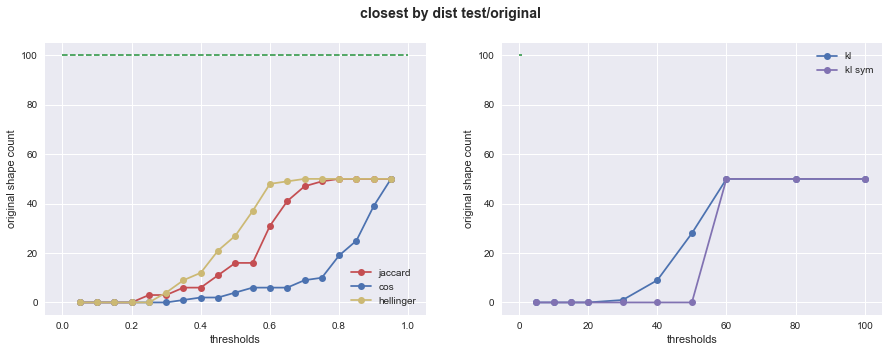

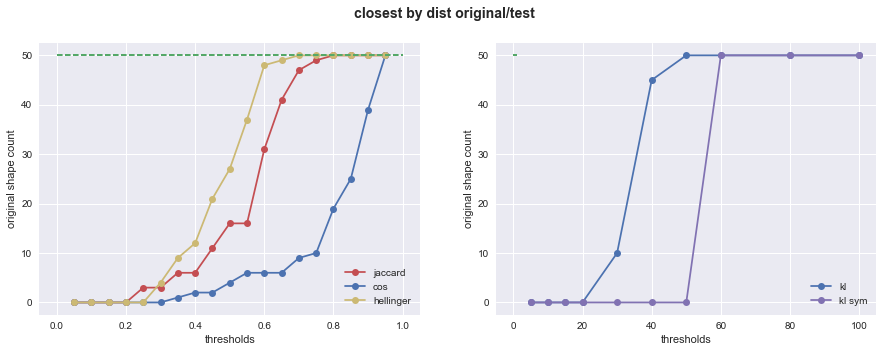

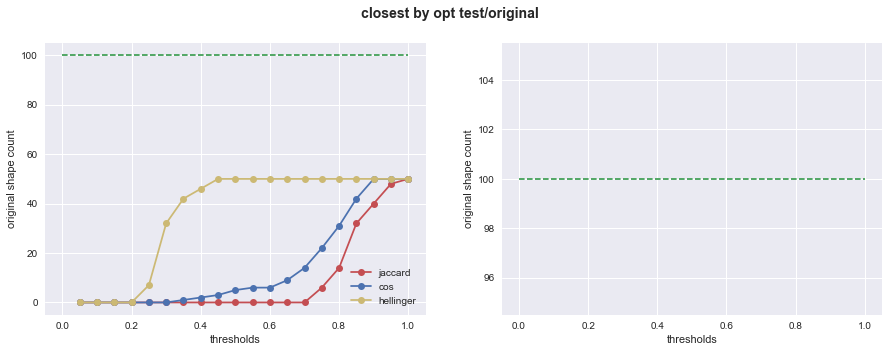

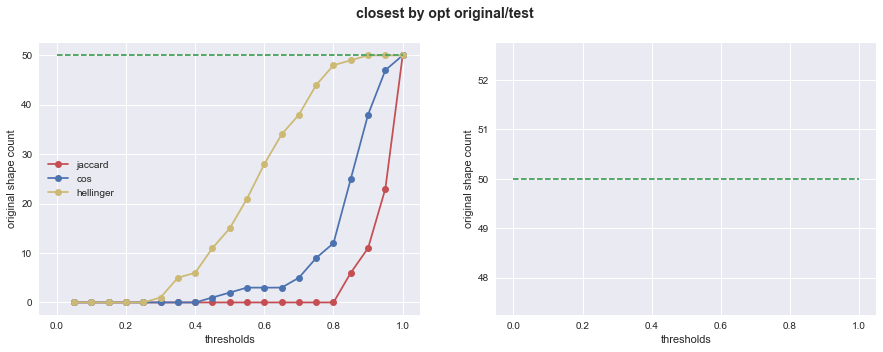

In [8]:
def create_model_dtn_50(n_iteration, model_name='', fit=True, n_topics=50):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 22
functions_list[idx] = create_model_dtn_50
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

*  -> , 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**:  
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|   	|       |       |    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|    	|    	|    	|   	|
| closest by opt res original/test 	|  - 	|   - 	|   -	|    	||
* **Выводы**: 
* **TODO**: 


name = create_model_dtn_100_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 100, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_57', u'topic_58', u'topic_59', u'topic_60', u'topic_61', u'topic_62', u'topi

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   100.00
non zero ratio                    0.96     0.83
|phi_ij == 0| / n_topics       2126.43  1843.23
|phi_ij > 0.2| / n_topics         0.23     0.66
|phi_ij > 0.1| / n_topics         0.89     1.54
|phi_ij > 0.01| / n_topics       27.16    19.91
|phi_ij > 0.05| / n_topics        2.63     3.93
|phi_ij > 0.001| / n_topics      80.26    56.52
topic_kernel_average_size        23.68    23.88
topic_kernel_average_purity       0.63     0.68
topic_kernel_average_contrast     0.78     0.79

Dist fn = <function kl_sym_dist at 0x000000000BCE9908>, Processed th = 100, original columns count = 100        Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Dist fn = <function cos_dist at 0x000000000BCE9A58>, Processed th = 1.0, original columns count = 100           Column topic_1 not optimized
Column topic_15 not optimized
Column topic_33 not optimized
Column topic_36 not optimized
Column topic_46 not optimized
Column topic_73 not optimized
Column topic_87 not optimized
Dist fn = <fu

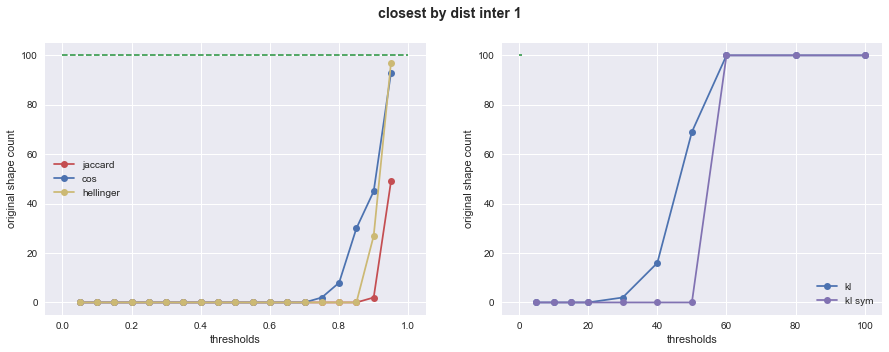

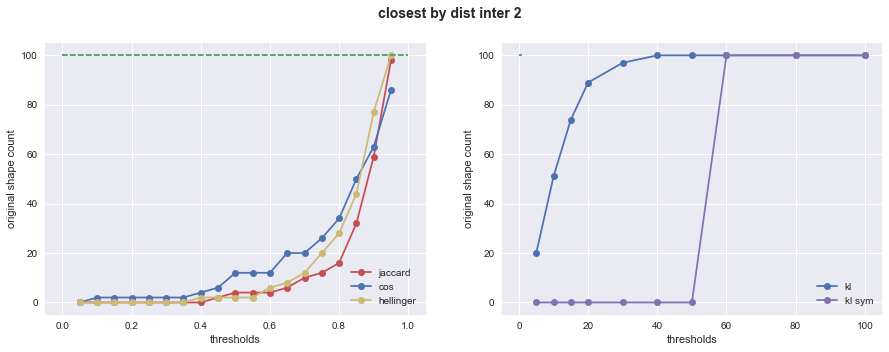

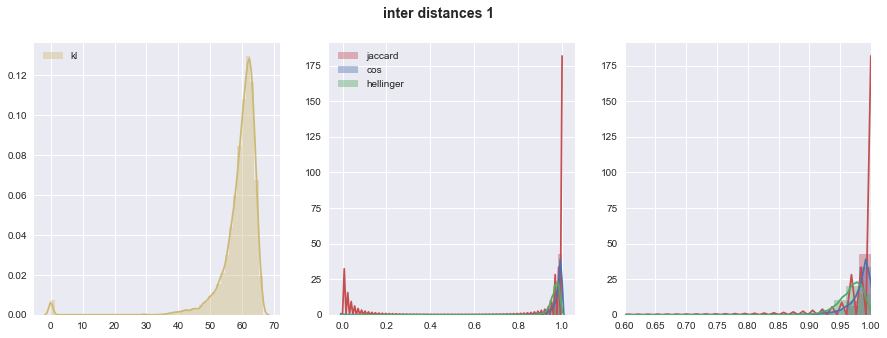

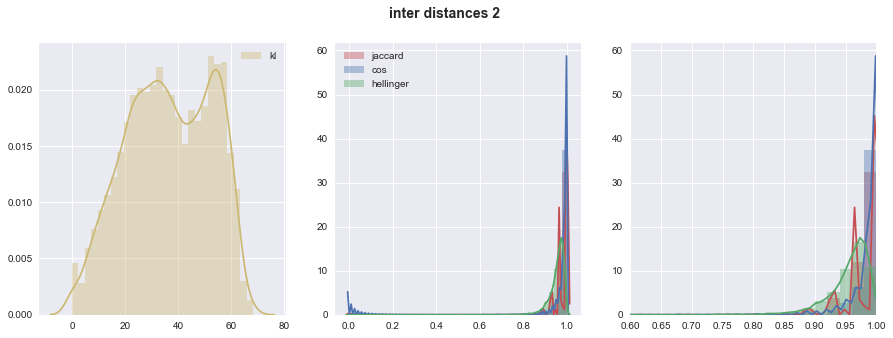

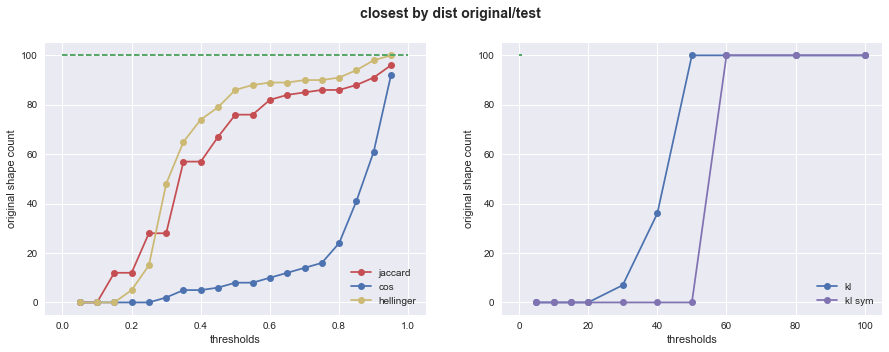

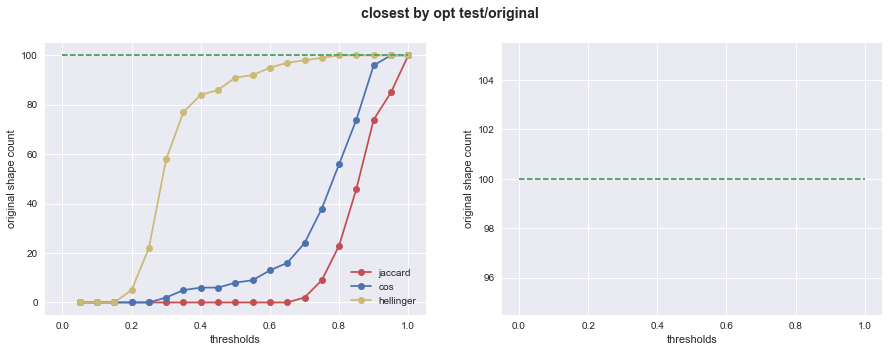

In [9]:
def create_model_dtn_100(n_iteration, model_name='', fit=True, n_topics=100):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 23
functions_list[idx] = create_model_dtn_100
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

*  -> , 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**: 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|   	|       |       |    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|    	|    	|    	|   	|
| closest by opt res original/test 	|  - 	|   - 	|   -	|    	||
* **Выводы**: 
* **TODO**: 


name = create_model_dtn_150_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 150, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_57', u'topic_58', u'topic_59', u'topic_60', u'topic_61', u'topic_62', u'topi

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   150.00
non zero ratio                    0.96     0.85
|phi_ij == 0| / n_topics       2126.43  1881.90
|phi_ij > 0.2| / n_topics         0.23     0.63
|phi_ij > 0.1| / n_topics         0.89     1.61
|phi_ij > 0.01| / n_topics       27.16    19.11
|phi_ij > 0.05| / n_topics        2.63     3.99
|phi_ij > 0.001| / n_topics      80.26    45.23
topic_kernel_average_size        23.68    16.00
topic_kernel_average_purity       0.63     0.64
topic_kernel_average_contrast     0.78     0.73

Dist fn = <function kl_sym_dist at 0x000000000BCE9908>, Processed th = 100, original columns count = 150        Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Dist fn = <function cos_dist at 0x000000000BCE9A58>, Processed th = 1.0, original columns count = 100           Column topic_1 not optimized
Column topic_2 not optimized
Column topic_15 not optimized
Column topic_32 not optimized
Column topic_41 not optimized
Column topic_51 not optimized
Column topic_62 not optimized
Column topic_7

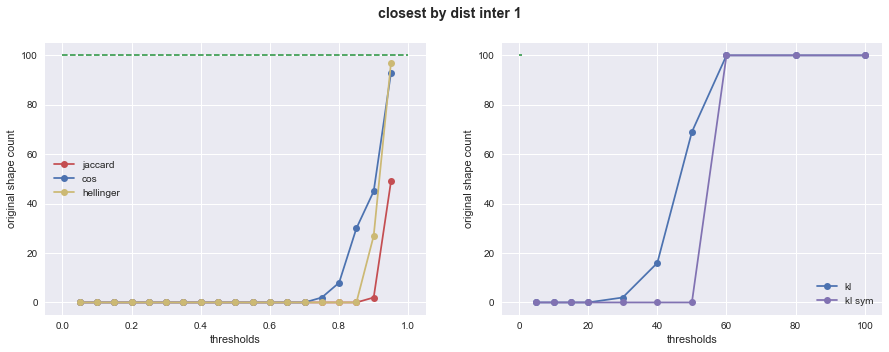

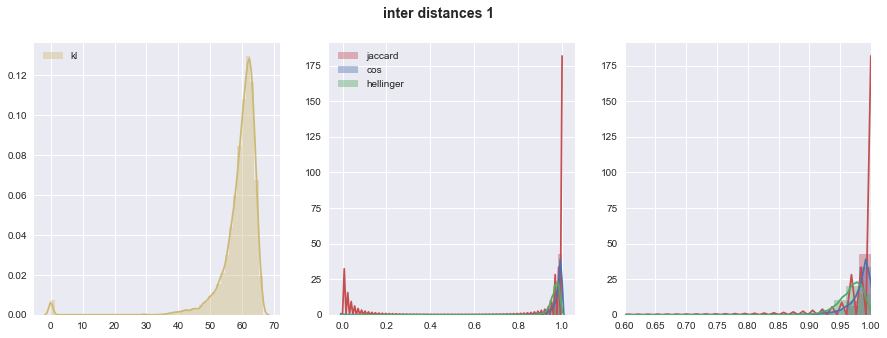

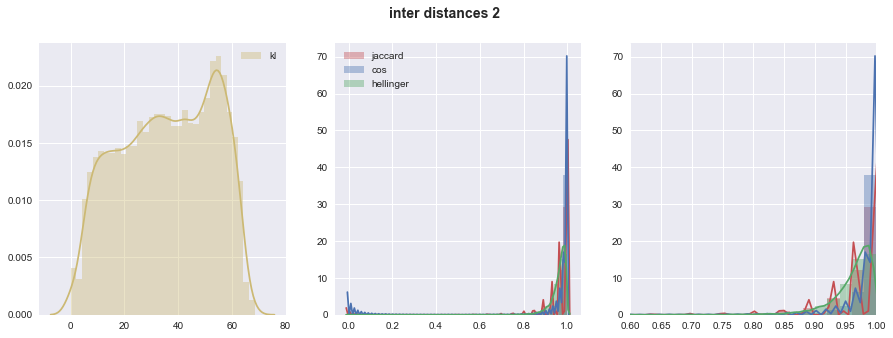

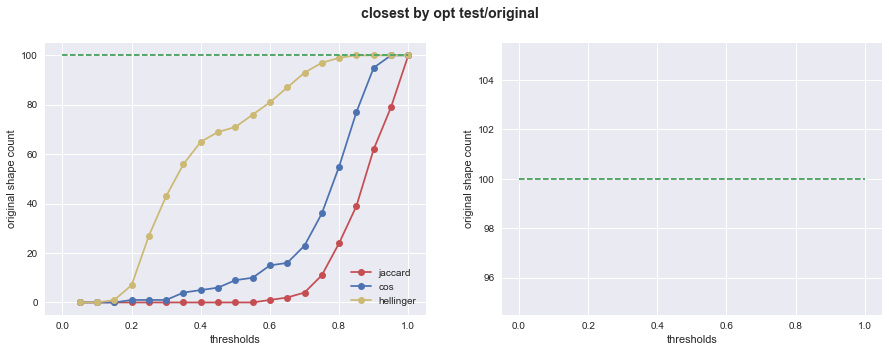

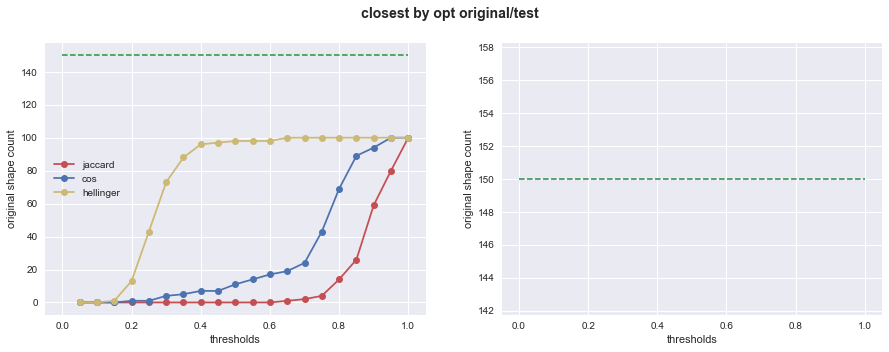

In [10]:
def create_model_dtn_150(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 24
functions_list[idx] = create_model_dtn_150
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

*  -> , 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**: 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|   	|       |       |    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|    	|    	|    	|   	|
| closest by opt res original/test 	|  - 	|   - 	|   -	|    	||
* **Выводы**: 
* **TODO**: 


name = create_model_dtn_200_iter_0, n_topics = 200, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 200, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_57', u'topic_58', u'topic_59', u'topic_60', u'topic_61', u'topic_62', u'topi

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   200.00
non zero ratio                    0.96     0.85
|phi_ij == 0| / n_topics       2126.43  1882.18
|phi_ij > 0.2| / n_topics         0.23     0.72
|phi_ij > 0.1| / n_topics         0.89     1.69
|phi_ij > 0.01| / n_topics       27.16    18.30
|phi_ij > 0.05| / n_topics        2.63     3.84
|phi_ij > 0.001| / n_topics      80.26    41.59
topic_kernel_average_size        23.68    12.12
topic_kernel_average_purity       0.63     0.58
topic_kernel_average_contrast     0.78     0.68

Dist fn = <function kl_sym_dist at 0x000000000BCE9908>, Processed th = 100, original columns count = 200        Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Dist fn = <function cos_dist at 0x000000000BCE9A58>, Processed th = 1.0, original columns count = 100           Column topic_1 not optimized
Column topic_5 not optimized
Column topic_12 not optimized
Column topic_32 not optimized
Column topic_36 not optimized
Column topic_48 not optimized
Column topic_57 not optimized
Column topic_7

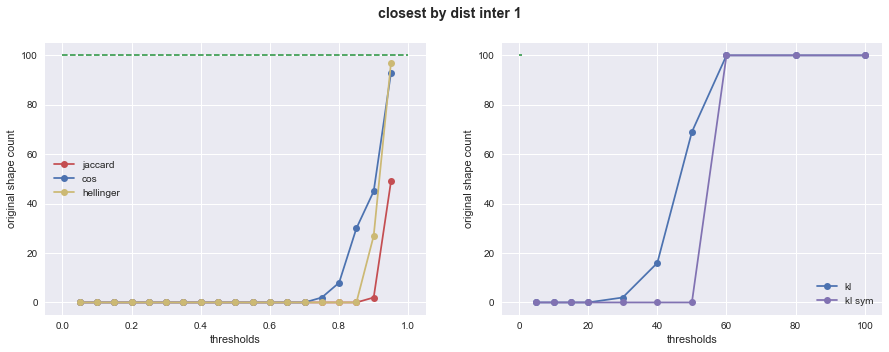

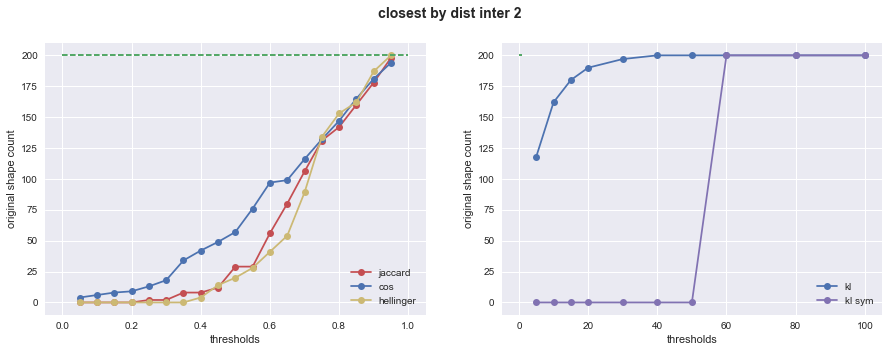

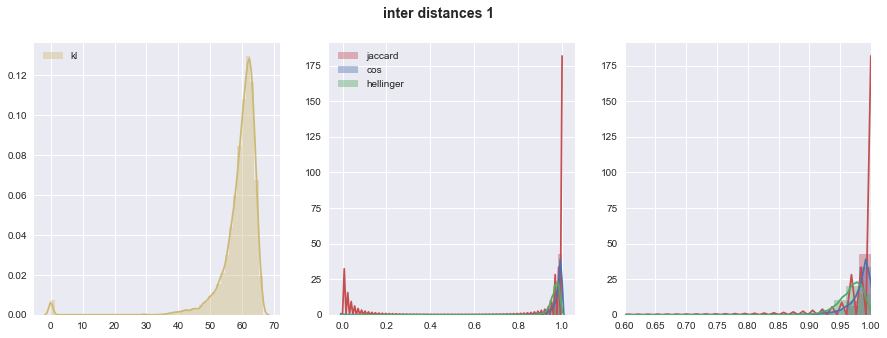

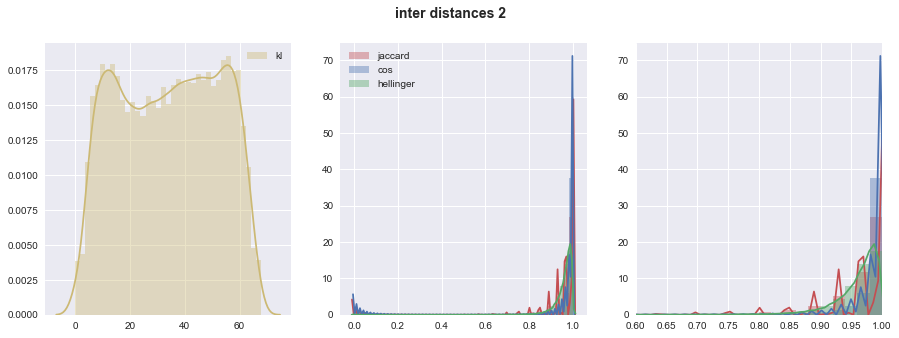

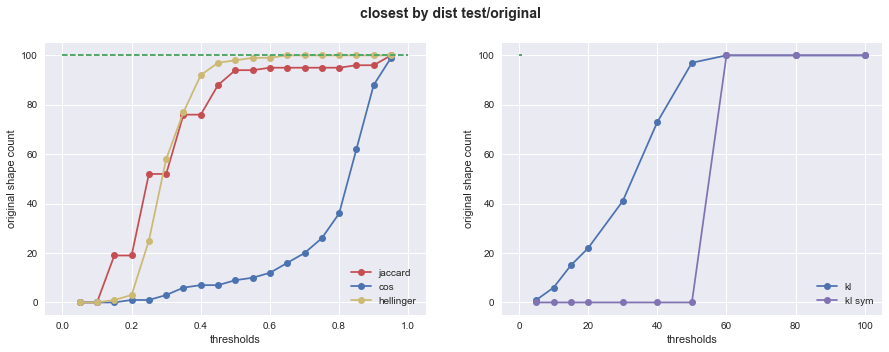

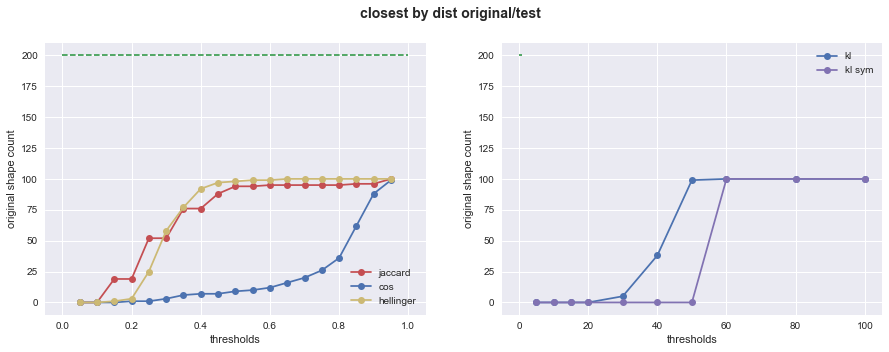

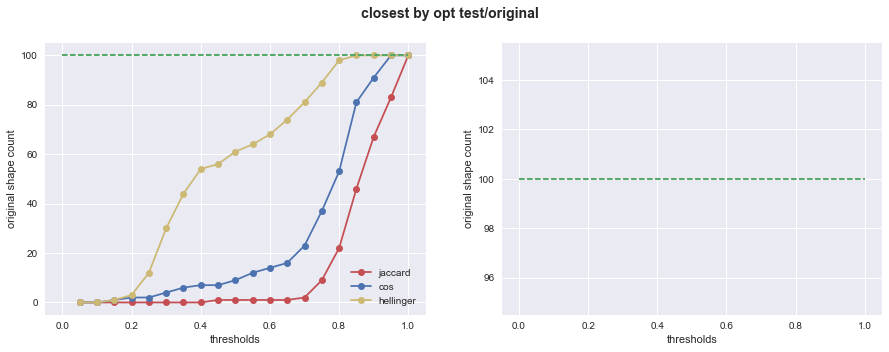

In [11]:
def create_model_dtn_200(n_iteration, model_name='', fit=True, n_topics=200):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 25
functions_list[idx] = create_model_dtn_200
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

*  -> , 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**: 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|   	|       |       |    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|    	|    	|    	|   	|
| closest by opt res original/test 	|  - 	|   - 	|   -	|    	||
* **Выводы**: 
* **TODO**: 


name = create_model_dtn_250_iter_0, n_topics = 250, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 250, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_57', u'topic_58', u'topic_59', u'topic_60', u'topic_61', u'topic_62', u'topi

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   250.00
non zero ratio                    0.96     0.85
|phi_ij == 0| / n_topics       2126.43  1891.91
|phi_ij > 0.2| / n_topics         0.23     0.78
|phi_ij > 0.1| / n_topics         0.89     1.68
|phi_ij > 0.01| / n_topics       27.16    17.06
|phi_ij > 0.05| / n_topics        2.63     3.92
|phi_ij > 0.001| / n_topics      80.26    37.80
topic_kernel_average_size        23.68     9.96
topic_kernel_average_purity       0.63     0.57
topic_kernel_average_contrast     0.78     0.63

Dist fn = <function kl_sym_dist at 0x000000000BCE9908>, Processed th = 100, original columns count = 250        Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Dist fn = <function cos_dist at 0x000000000BCE9A58>, Processed th = 1.0, original columns count = 100           Column topic_2 not optimized
Column topic_15 not optimized
Column topic_21 not optimized
Column topic_30 not optimized
Column topic_36 not optimized
Column topic_41 not optimized
Column topic_46 not optimized
Column topic_

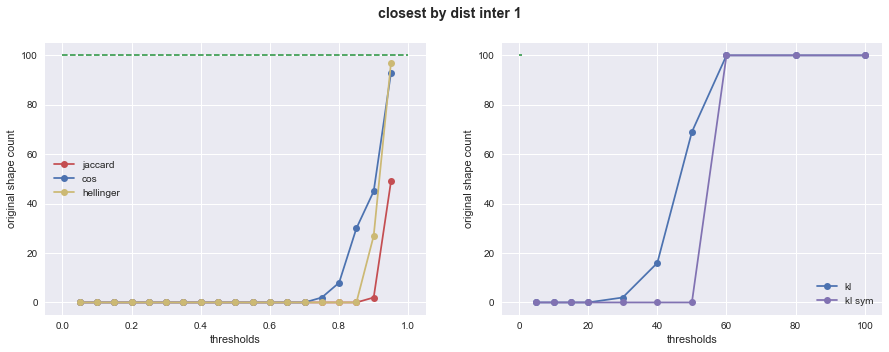

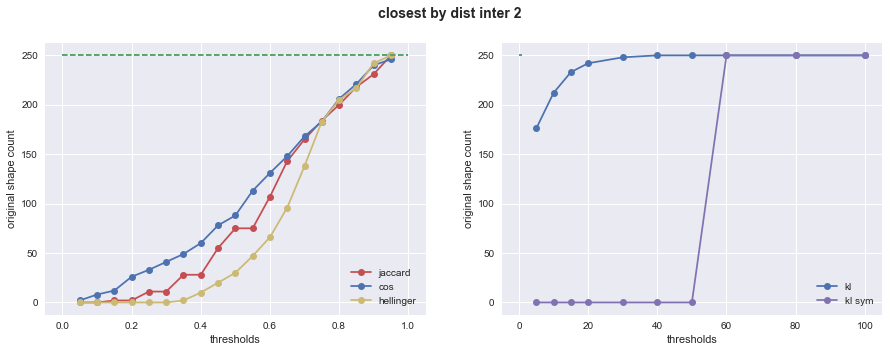

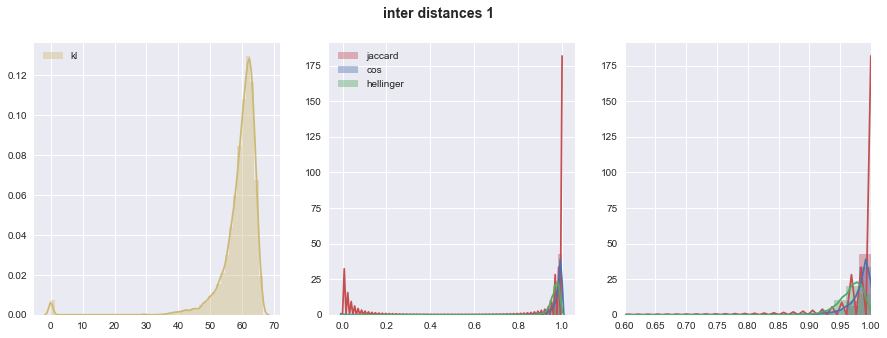

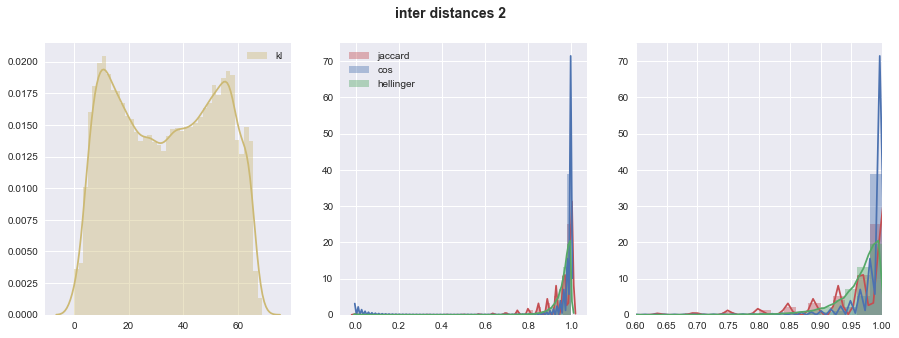

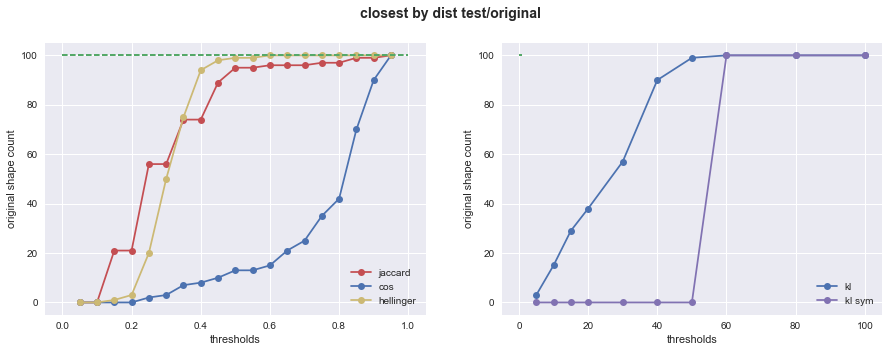

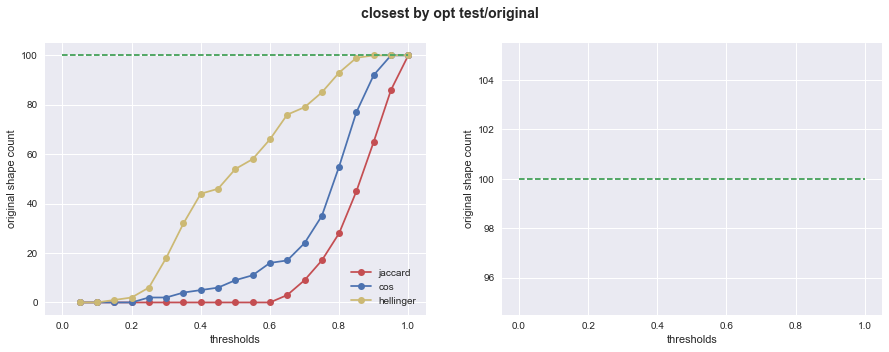

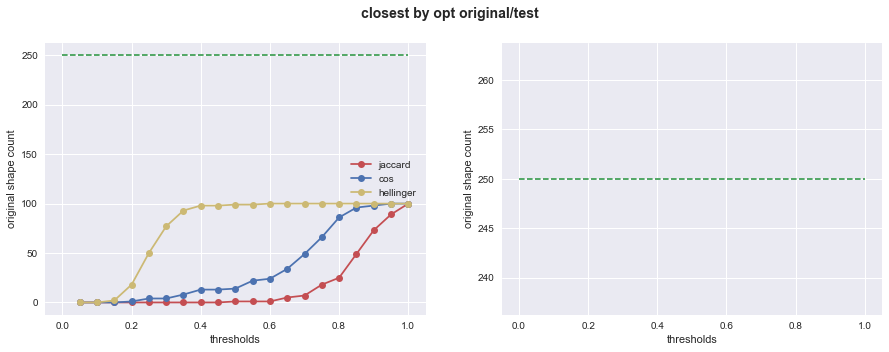

In [12]:
def create_model_dtn_250(n_iteration, model_name='', fit=True, n_topics=250):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 26
functions_list[idx] = create_model_dtn_250
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

*  -> , 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**: 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|   	|       |       |    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|    	|    	|    	|   	|
| closest by opt res original/test 	|  - 	|   - 	|   -	|    	||
* **Выводы**: 
* **TODO**: 


name = create_model_dtn_300_iter_0, n_topics = 300, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 300, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_57', u'topic_58', u'topic_59', u'topic_60', u'topic_61', u'topic_62', u'topi

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   300.00
non zero ratio                    0.96     0.86
|phi_ij == 0| / n_topics       2126.43  1899.47
|phi_ij > 0.2| / n_topics         0.23     0.82
|phi_ij > 0.1| / n_topics         0.89     1.75
|phi_ij > 0.01| / n_topics       27.16    16.03
|phi_ij > 0.05| / n_topics        2.63     3.99
|phi_ij > 0.001| / n_topics      80.26    35.43
topic_kernel_average_size        23.68     8.18
topic_kernel_average_purity       0.63     0.55
topic_kernel_average_contrast     0.78     0.61

Dist fn = <function kl_sym_dist at 0x000000000BCE9908>, Processed th = 100, original columns count = 300        Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Dist fn = <function cos_dist at 0x000000000BCE9A58>, Processed th = 1.0, original columns count = 100           Column topic_1 not optimized
Column topic_2 not optimized
Column topic_30 not optimized
Column topic_40 not optimized
Column topic_41 not optimized
Column topic_42 not optimized
Column topic_44 not optimized
Column topic_5

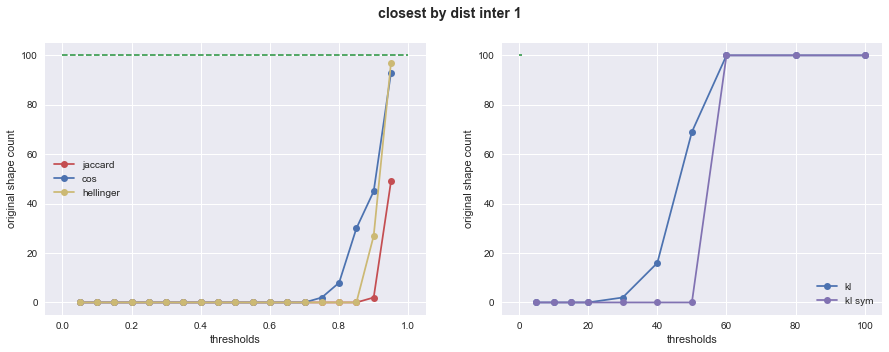

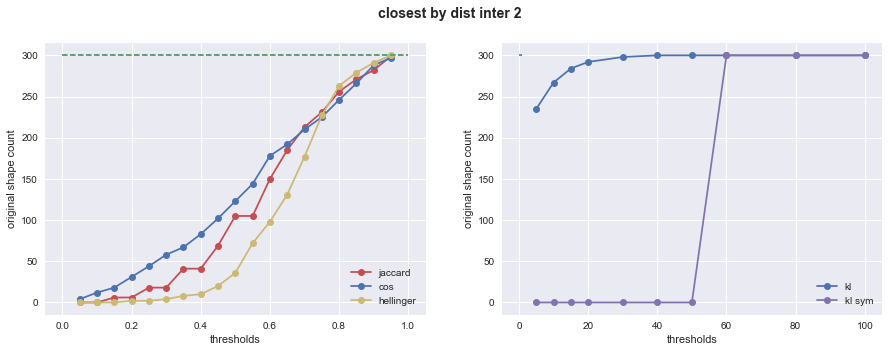

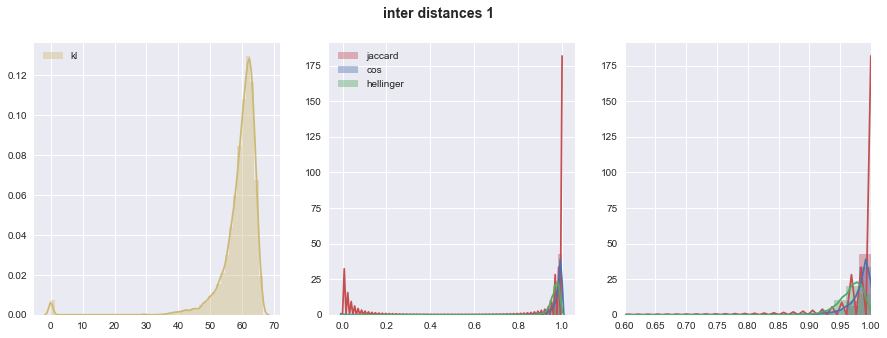

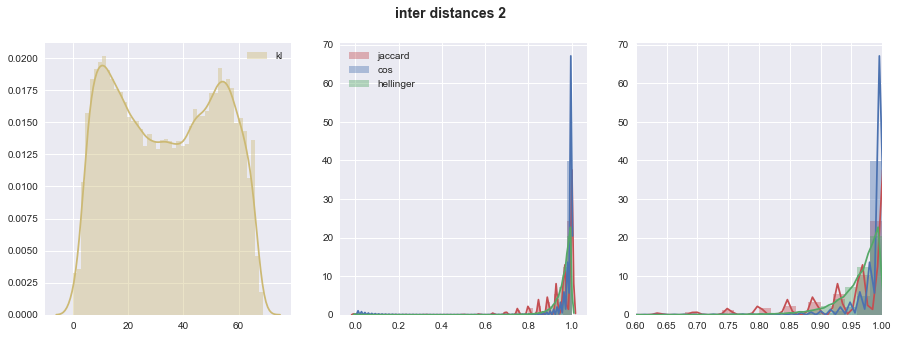

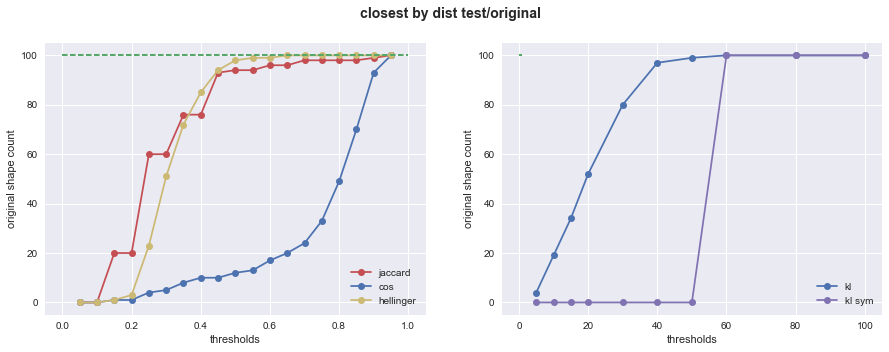

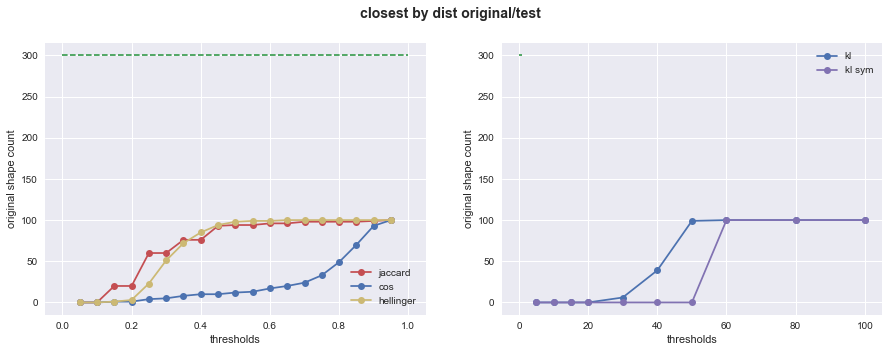

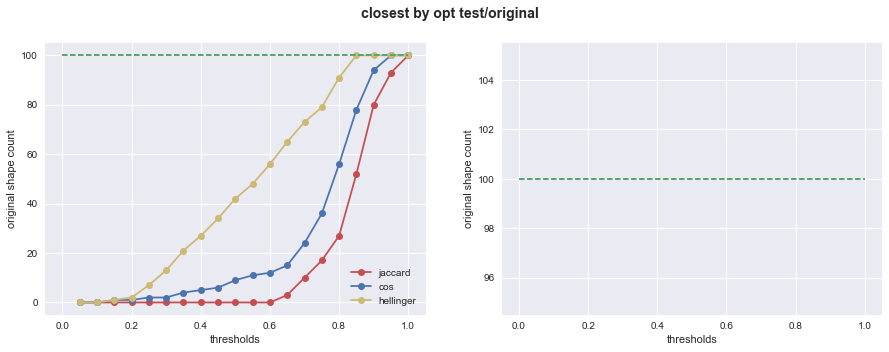

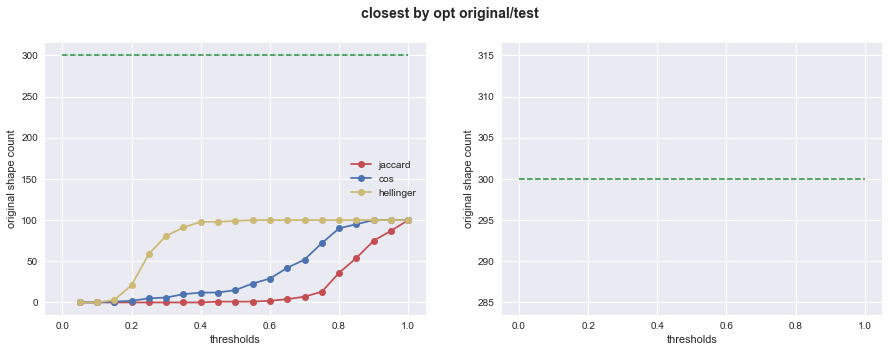

In [13]:
def create_model_dtn_300(n_iteration, model_name='', fit=True, n_topics=300):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 27
functions_list[idx] = create_model_dtn_300
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

*  -> , 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**: 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|   	|       |       |    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|    	|    	|    	|   	|
| closest by opt res original/test 	|  - 	|   - 	|   -	|    	||
* **Выводы**: 
* **TODO**: 


name = create_model_dtn_350_iter_0, n_topics = 350, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 350, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_57', u'topic_58', u'topic_59', u'topic_60', u'topic_61', u'topic_62', u'topi

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   350.00
non zero ratio                    0.96     0.86
|phi_ij == 0| / n_topics       2126.43  1904.45
|phi_ij > 0.2| / n_topics         0.23     0.83
|phi_ij > 0.1| / n_topics         0.89     1.78
|phi_ij > 0.01| / n_topics       27.16    15.52
|phi_ij > 0.05| / n_topics        2.63     3.98
|phi_ij > 0.001| / n_topics      80.26    33.80
topic_kernel_average_size        23.68     7.18
topic_kernel_average_purity       0.63     0.54
topic_kernel_average_contrast     0.78     0.58

Dist fn = <function kl_sym_dist at 0x000000000BCE9908>, Processed th = 100, original columns count = 350        Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Dist fn = <function cos_dist at 0x000000000BCE9A58>, Processed th = 1.0, original columns count = 100           Column topic_320 not optimized
Column topic_346 not optimized
Dist fn = <function cos_dist at 0x000000000BCE9A58>, Processed th = 1.0, original columns count = 100           Column topic_26 not optimized
Column topic_32 no

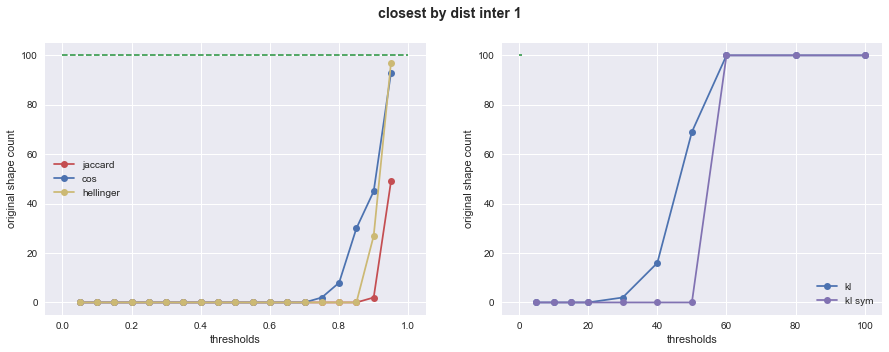

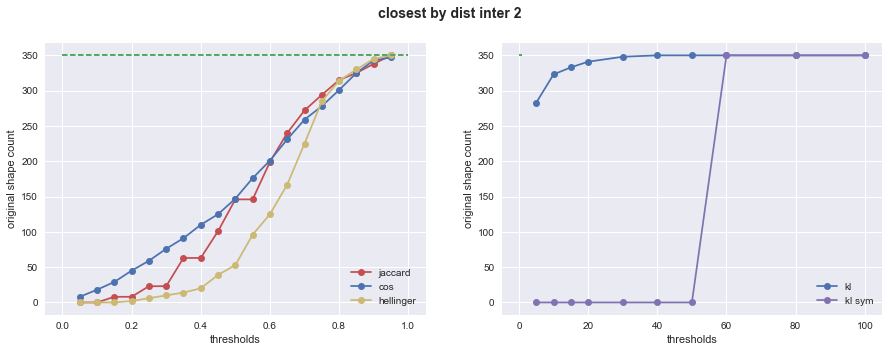

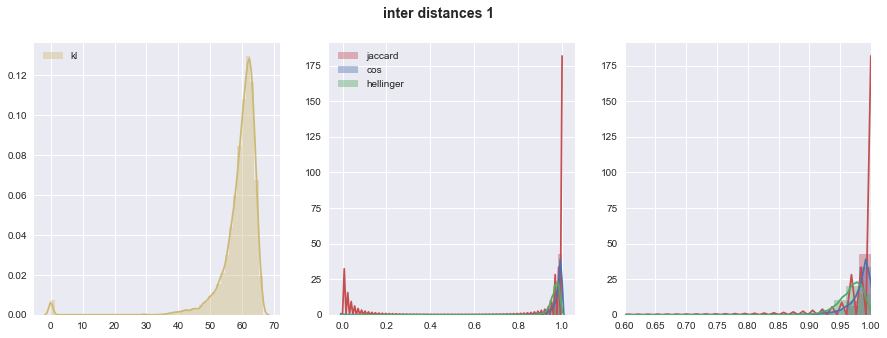

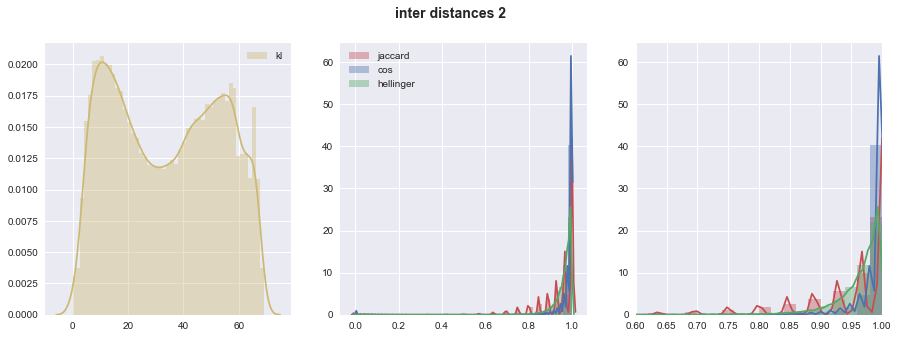

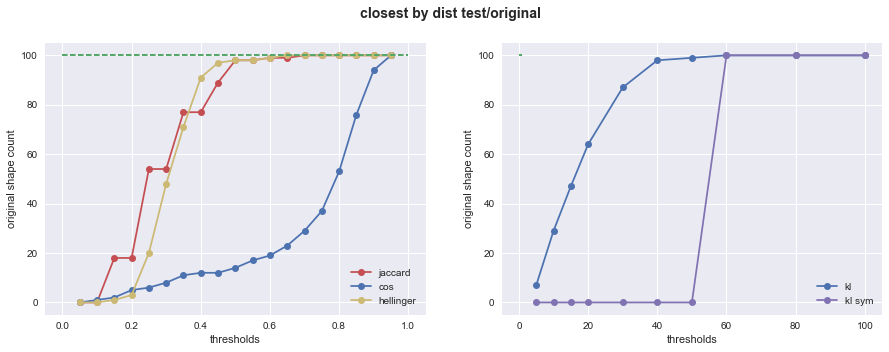

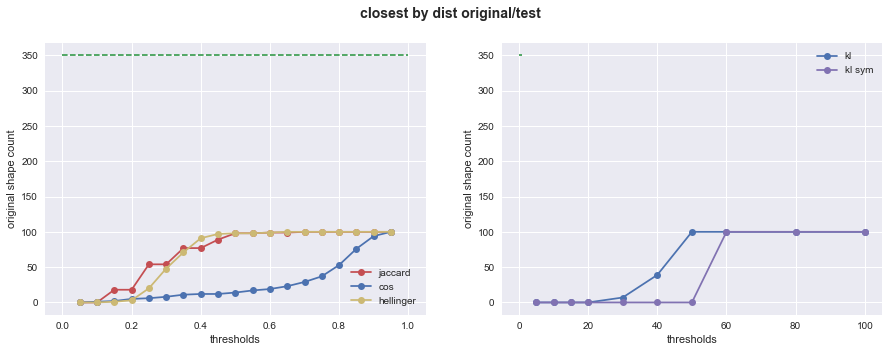

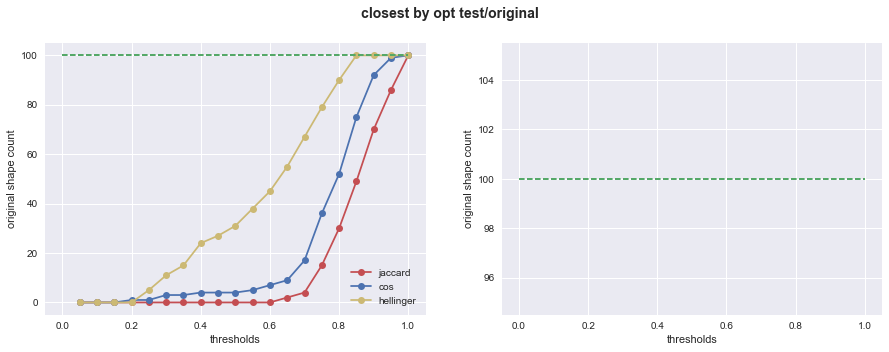

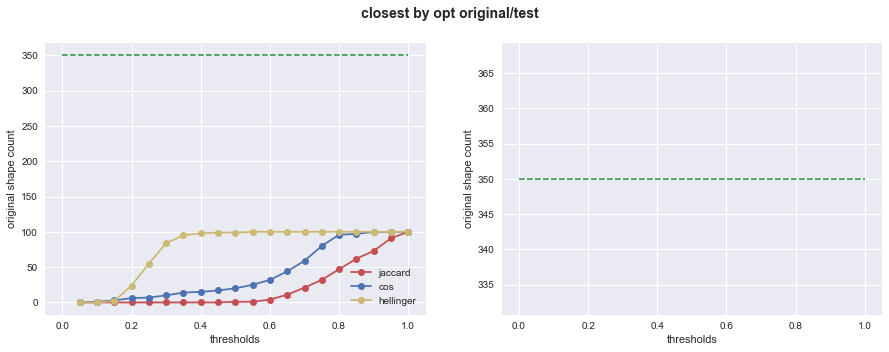

In [14]:
def create_model_dtn_350(n_iteration, model_name='', fit=True, n_topics=350):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 28
functions_list[idx] = create_model_dtn_350
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

*  -> , 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**: 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|   	|       |       |    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|    	|    	|    	|   	|
| closest by opt res original/test 	|  - 	|   - 	|   -	|    	||
* **Выводы**: 
* **TODO**: 


name = create_model_dtn_400_iter_0, n_topics = 400, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 400, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_57', u'topic_58', u'topic_59', u'topic_60', u'topic_61', u'topic_62', u'topi

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   400.00
non zero ratio                    0.96     0.86
|phi_ij == 0| / n_topics       2126.43  1906.16
|phi_ij > 0.2| / n_topics         0.23     0.89
|phi_ij > 0.1| / n_topics         0.89     1.85
|phi_ij > 0.01| / n_topics       27.16    14.67
|phi_ij > 0.05| / n_topics        2.63     3.88
|phi_ij > 0.001| / n_topics      80.26    32.55
topic_kernel_average_size        23.68     6.32
topic_kernel_average_purity       0.63     0.53
topic_kernel_average_contrast     0.78     0.54

Dist fn = <function kl_sym_dist at 0x000000000BCE9908>, Processed th = 100, original columns count = 400        Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Dist fn = <function cos_dist at 0x000000000BCE9A58>, Processed th = 1.0, original columns count = 100           Column topic_2 not optimized
Column topic_17 not optimized
Column topic_21 not optimized
Column topic_24 not optimized
Column topic_40 not optimized
Column topic_41 not optimized
Column topic_51 not optimized
Column topic_

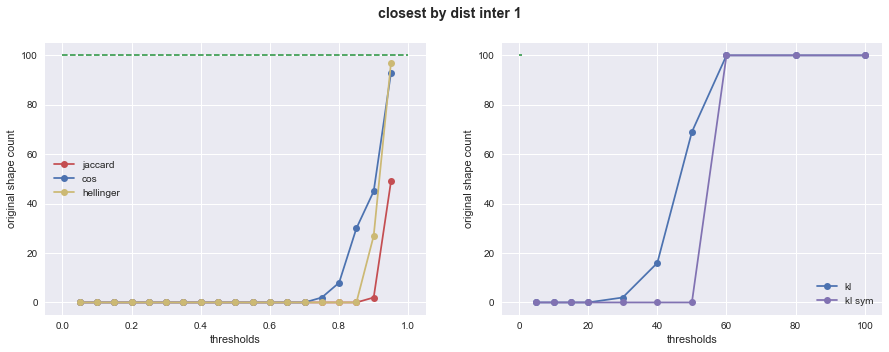

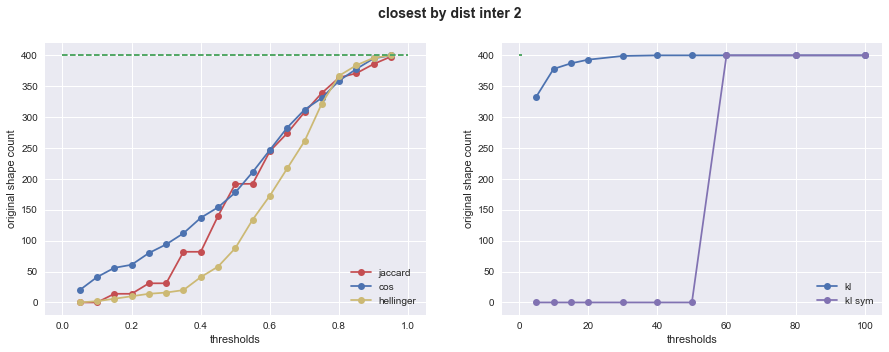

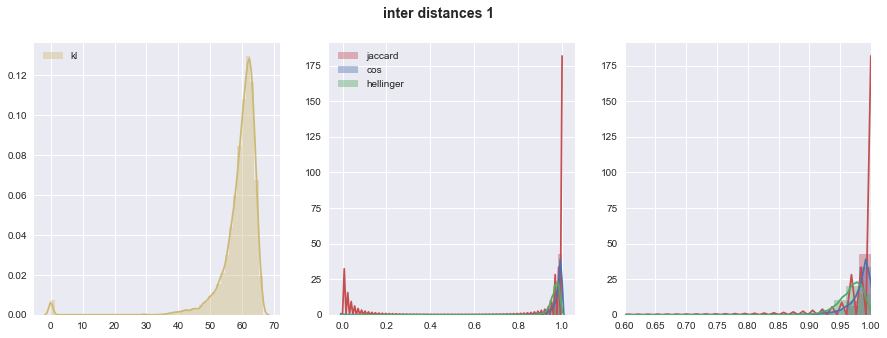

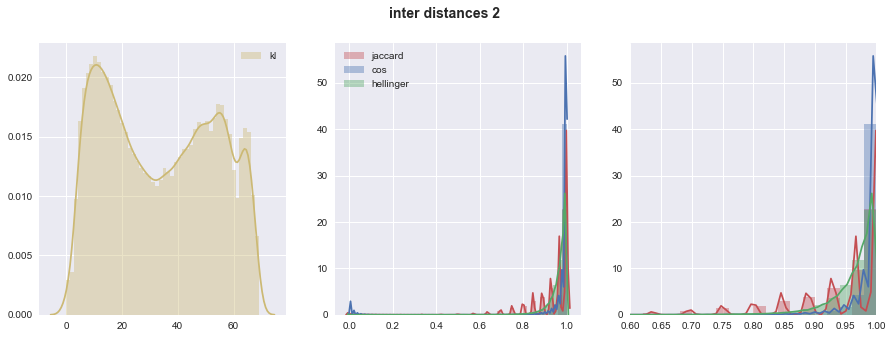

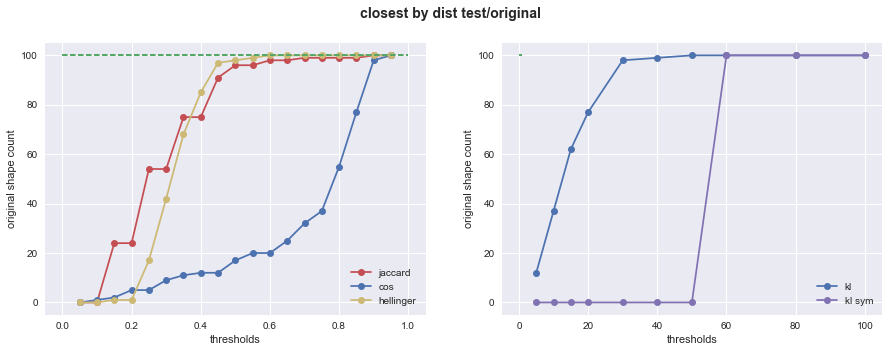

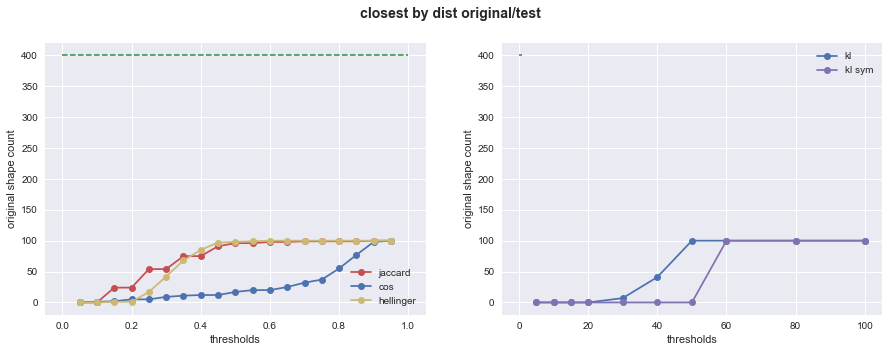

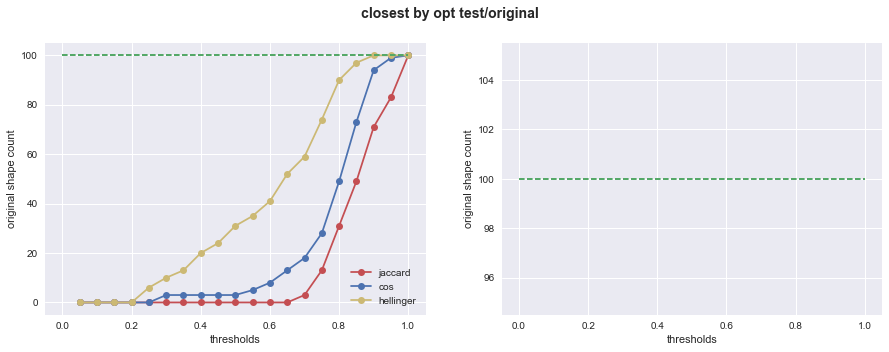

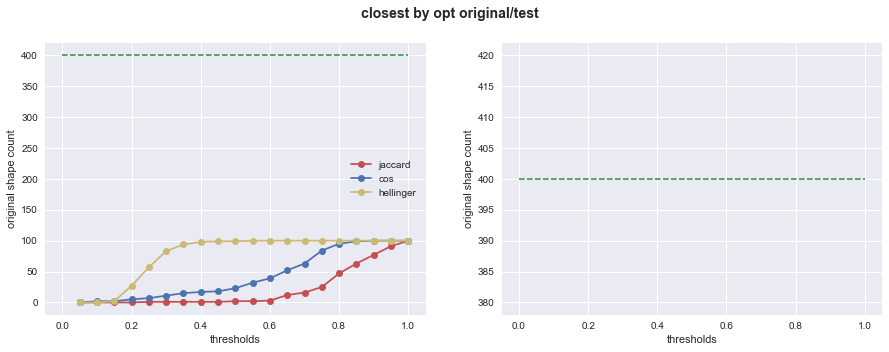

In [15]:
def create_model_dtn_400(n_iteration, model_name='', fit=True, n_topics=400):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 29
functions_list[idx] = create_model_dtn_400
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

*  -> , 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**: 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|   	|       |       |    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|    	|    	|    	|   	|
| closest by opt res original/test 	|  - 	|   - 	|   -	|    	||
* **Выводы**: 
* **TODO**: 


name = create_model_dtn_500_iter_0, n_topics = 500, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 500, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_57', u'topic_58', u'topic_59', u'topic_60', u'topic_61', u'topic_62', u'topi

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   500.00
non zero ratio                    0.96     0.86
|phi_ij == 0| / n_topics       2126.43  1911.16
|phi_ij > 0.2| / n_topics         0.23     0.88
|phi_ij > 0.1| / n_topics         0.89     1.83
|phi_ij > 0.01| / n_topics       27.16    13.70
|phi_ij > 0.05| / n_topics        2.63     3.86
|phi_ij > 0.001| / n_topics      80.26    30.85
topic_kernel_average_size        23.68     5.06
topic_kernel_average_purity       0.63     0.49
topic_kernel_average_contrast     0.78     0.48

Dist fn = <function kl_sym_dist at 0x000000000BCE9908>, Processed th = 100, original columns count = 500        Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Dist fn = <function cos_dist at 0x000000000BCE9A58>, Processed th = 1.0, original columns count = 100           Column topic_1 not optimized
Column topic_2 not optimized
Column topic_15 not optimized
Column topic_32 not optimized
Column topic_40 not optimized
Column topic_41 not optimized
Column topic_54 not optimized
Column topic_6

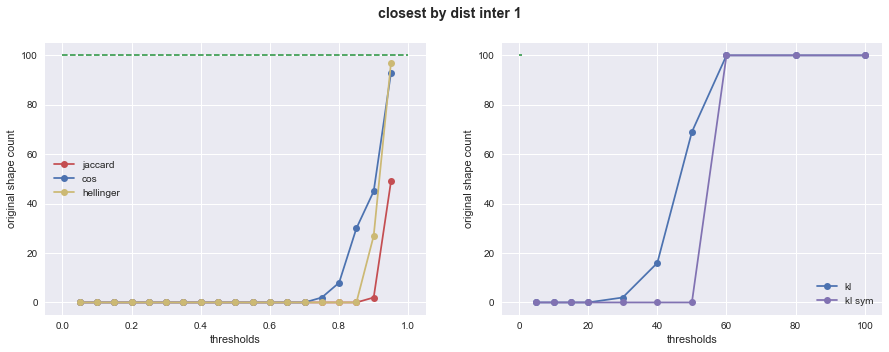

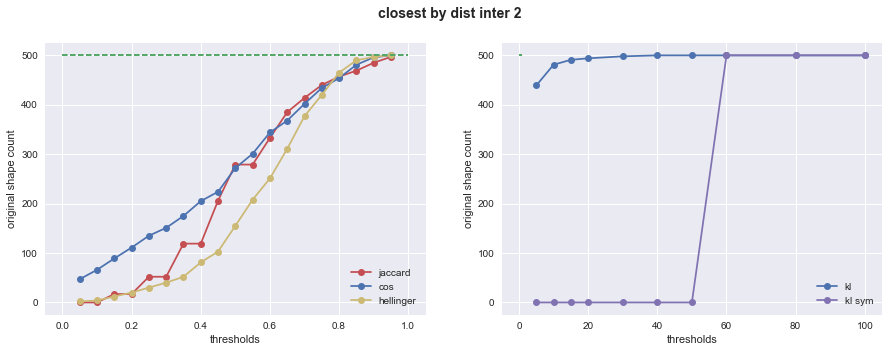

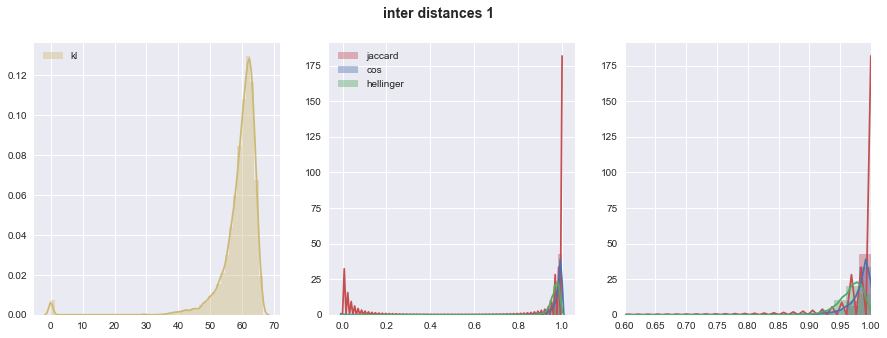

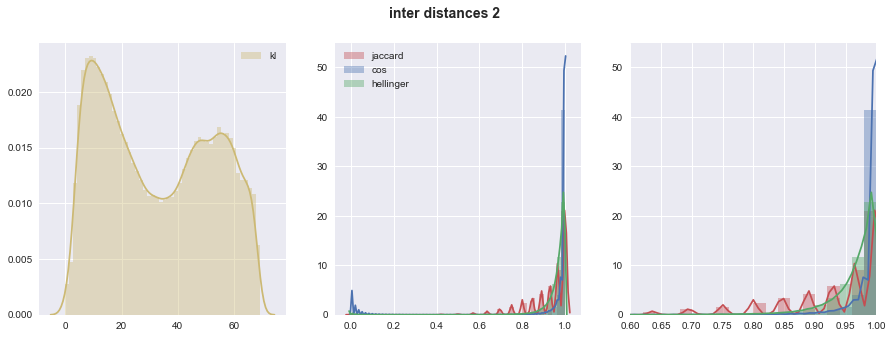

In [16]:
def create_model_dtn_500(n_iteration, model_name='', fit=True, n_topics=500):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 30
functions_list[idx] = create_model_dtn_500
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

*  -> , 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**: 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|   	|       |       |    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|    	|    	|    	|   	|
| closest by opt res original/test 	|  - 	|   - 	|   -	|    	||
* **Выводы**: 
* **TODO**: 


name = create_model_dtn_750_iter_0, n_topics = 750, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 750, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_57', u'topic_58', u'topic_59', u'topic_60', u'topic_61', u'topic_62', u'topi

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   750.00
non zero ratio                    0.96     0.87
|phi_ij == 0| / n_topics       2126.43  1922.41
|phi_ij > 0.2| / n_topics         0.23     0.96
|phi_ij > 0.1| / n_topics         0.89     1.88
|phi_ij > 0.01| / n_topics       27.16    12.22
|phi_ij > 0.05| / n_topics        2.63     3.67
|phi_ij > 0.001| / n_topics      80.26    27.83
topic_kernel_average_size        23.68     3.43
topic_kernel_average_purity       0.63     0.39
topic_kernel_average_contrast     0.78     0.39

Dist fn = <function kl_sym_dist at 0x000000000BCE9908>, Processed th = 100, original columns count = 750        Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Processing <function jaccard_dist at 0x000000000BCE9978>
Processing <function cos_dist at 0x000000000BCE9A58>
Processing <function hellinger_dist at 0x000000000BCE9AC8>
Processing <function kl_dist at 0x000000000BCE9898>
Processing <function kl_sym_dist at 0x000000000BCE9908>
Dist fn = <function hellinger_dist at 0x000000000BCE9AC8>, Processed th = 0.3, original columns count = 28      

KeyboardInterrupt: 

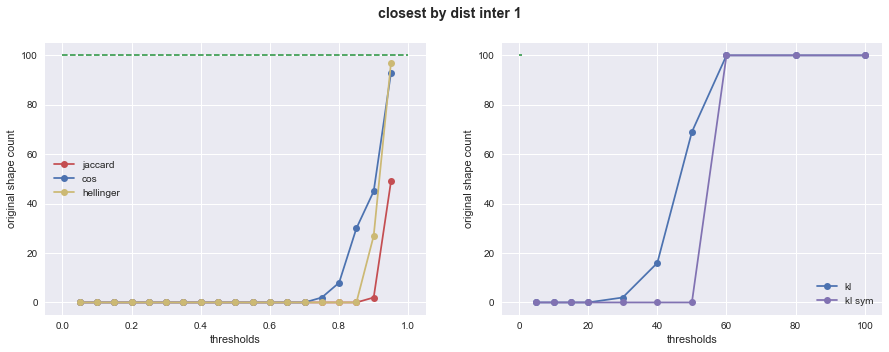

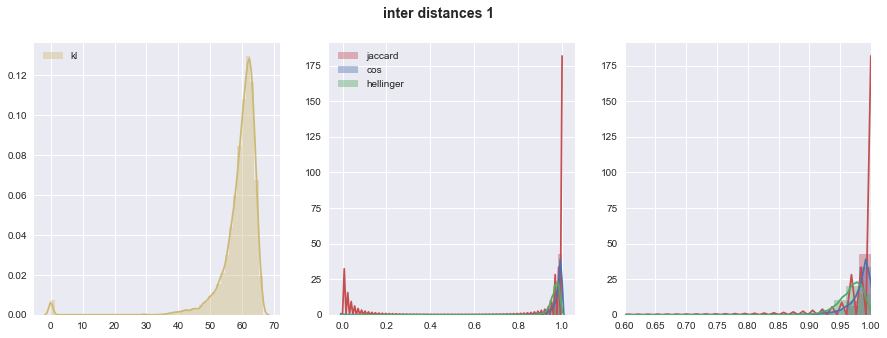

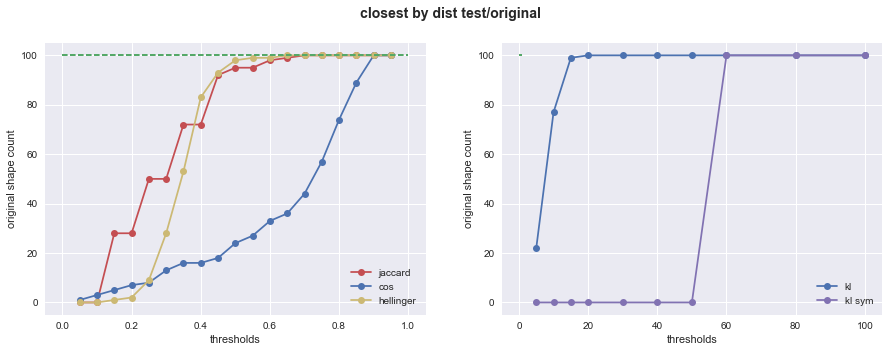

In [17]:
def create_model_dtn_750(n_iteration, model_name='', fit=True, n_topics=750):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 31
functions_list[idx] = create_model_dtn_750
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

*  -> , 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**: 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|   	|       |       |    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|    	|    	|    	|   	|
| closest by opt res original/test 	|  - 	|   - 	|   -	|    	||
* **Выводы**: 
* **TODO**: 


In [ ]:
def create_model_dtn_1000(n_iteration, model_name='', fit=True, n_topics=1000):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 32
functions_list[idx] = create_model_dtn_1000
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

*  -> , 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**: 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|   	|       |       |    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|    	|    	|    	|   	|
| closest by opt res original/test 	|  - 	|   - 	|   -	|    	||
* **Выводы**: 
* **TODO**: 


In [ ]:
def create_model_dtn_2000(n_iteration, model_name='', fit=True, n_topics=2000):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 33
functions_list[idx] = create_model_dtn_2000
names_list[idx] = functions_list[idx].__name__
models_list[idx] = functions_list[idx](0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

*  -> , 
* **kernel size**: 24 vs , **purity**: .63 vs ., **contrast** .78 vs ., **$phi_{ij}$**: 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|   	|       |       |    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|    	|    	|    	|   	|
| closest by opt res original/test 	|  - 	|   - 	|   -	|    	||
* **Выводы**: 
* **TODO**: 


In [ ]:
save_pickle_file([different_inter_distances_closest_1, different_inter_distances_closest_2, 
        different_inter_distances_1, different_inter_distances_2, 
        different_to_original_distances_closest_1, different_to_test_distances_closest_2, 
        different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix], 'result_no_reg.p')
save_pickle_file([names_list, phi_list, phi_nwt_list, theta_list,
                  phi_filtered_list, phi_nwt_filtered_list, theta_filtered_list], 'init_no_reg.p')